<a href="https://colab.research.google.com/github/ammarshibani/data-analysis-colab/blob/main/customer_behavior_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Customer Segmentation & High Spender Prediction**

### **1. Project Overview**

This document outlines the complete workflow of our customer segmentation and high-spender prediction project. We aim to:

- Understand customer behavior from transactional and demographic data through exploratory data analysis (EDA).
- Engineer meaningful **customer-level features** such as `TotalSpending`, `AvgTransactionValue`, `Recency`, and `PurchaseFrequency` for advanced modeling.
- Apply **unsupervised learning (K-Means Clustering)** to identify distinct customer segments based on behavioral patterns.
- Build a **logistic regression model** to predict whether a customer is a high spender (`IsHighSpender`) using engineered features.
- Provide **actionable insights and targeted marketing strategies** for each customer segment to improve engagement, retention, and revenue.

Our goal is to support data-driven decision-making in customer targeting and personalization strategies.

### **2. Steps Overview**

#### **Step 1: Data Loading & Preprocessing**

* Loaded two datasets:
  * `retail_sales_dataset.csv`: Contains transaction-level data (e.g., date, customer ID, product category, total amount).
  * `Customer.csv`: Contains demographic data about customers (e.g., age, gender, city).
* Merged both datasets using `Customer ID` with a **left join** to preserve all transaction records.
* Converted the `Date` column to **datetime format** for time-based analysis (e.g., recency calculation).
* Removed duplicate rows to ensure clean and consistent data.
* Displayed the shape and first 5 rows of the merged dataset:
  - Shape: `(1000, 12)` — 1000 transactions with 12 features.
  - Sample output showed key variables like `Total Amount`, `Product Category`, and `City`.


In [ ]:
import pandas as pd

# Load data
sales_df = pd.read_csv("retail_sales_dataset.csv")
customer_df = pd.read_csv("Customer.csv")

# Convert 'Date' to datetime
sales_df['Date'] = pd.to_datetime(sales_df['Date'])

# Merge on Customer ID
merged_df = pd.merge(sales_df, customer_df, on='Customer ID', how='left')

# Drop duplicates
merged_df.drop_duplicates(inplace=True)

# Show merged shape
print("Merged DataFrame Shape:", merged_df.shape)
print("\n", merged_df.head())

Merged DataFrame Shape: (1000, 12)

    Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   
3               4 2023-05-21     CUST004    Male   37         Clothing   
4               5 2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount    City Income Level Marital Status  
0         3              50           150  Riyadh         High         Single  
1         2             500          1000  Jeddah       Medium        Married  
2         1              30            30  Dammam         High         Single  
3         1             500           500  Riyadh          Low        Married  
4         2              50           100   Mecca       Medium         Single  


#### **Step 2: Exploratory Data Analysis (EDA)**

* Analyzed distributions of numerical features (`Age`, `Quantity`, `Price per Unit`, `Total Amount`) using histograms.
* Visualized relationships between variables using a **correlation matrix**:
  - Strong positive correlation (**+0.85**) between `Price per Unit` and `Total Amount`.
  - Weak negative correlation (**-0.06**) between `Age` and `Total Amount`.
* Used boxplots to compare `Total Amount` across different `Product Category`:
  - **Beauty** and **Electronics** had higher median spending values.
  - Highlighted presence of outliers in spending patterns.



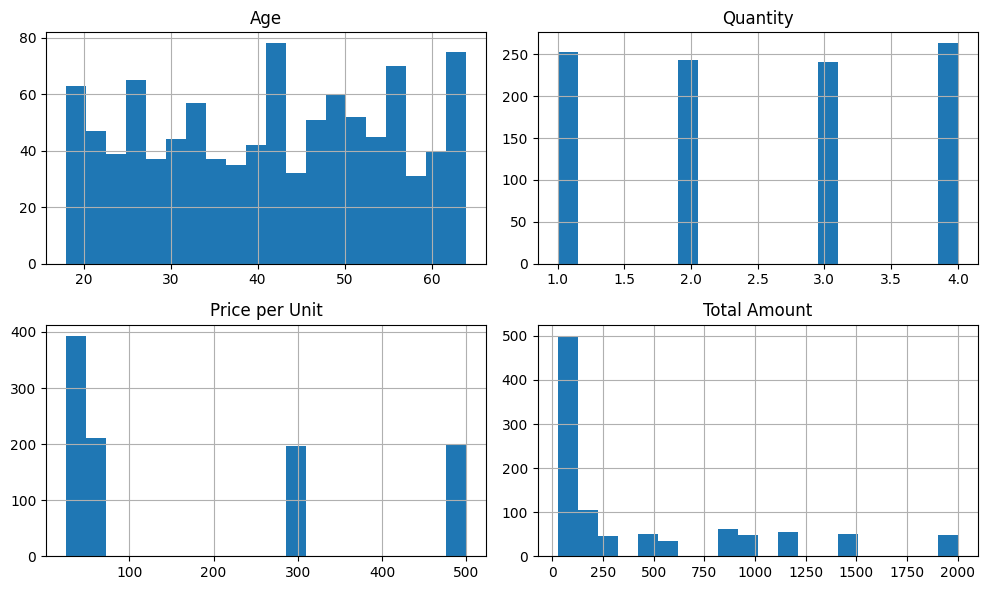

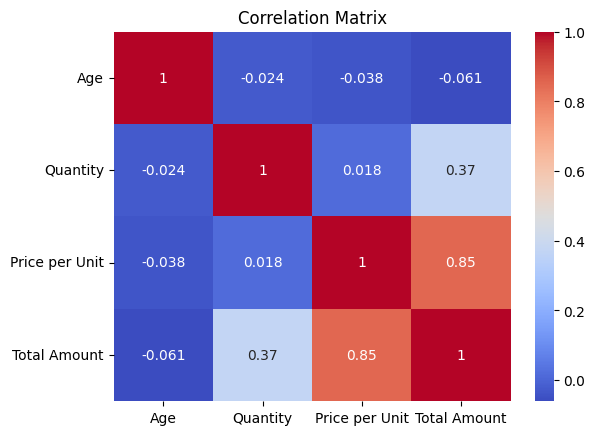

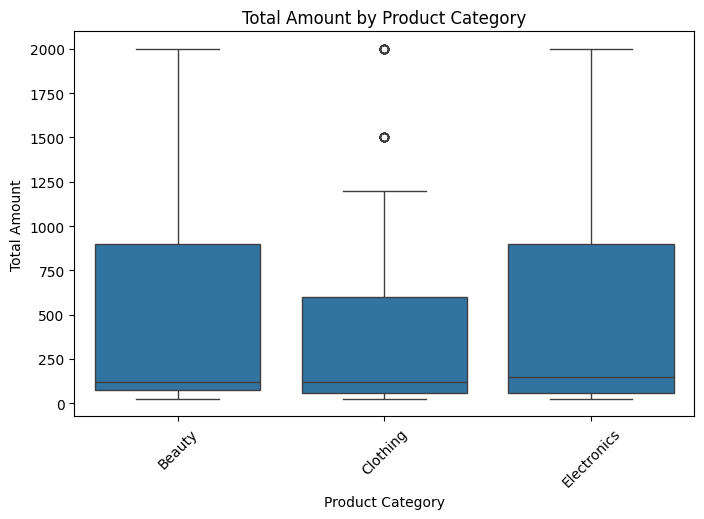

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for numerical features
merged_df[['Age', 'Quantity', 'Price per Unit', 'Total Amount']].hist(bins=20, figsize=(10, 6))
plt.tight_layout()
plt.show()

# Correlation matrix
sns.heatmap(merged_df[['Age', 'Quantity', 'Price per Unit', 'Total Amount']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplot: Total Amount by Product Category
plt.figure(figsize=(8, 5))
sns.boxplot(x='Product Category', y='Total Amount', data=merged_df)
plt.xticks(rotation=45)
plt.title('Total Amount by Product Category')
plt.show()

#### **Step 3: Feature Engineering**

* Aggregated transaction-level data to create **customer-level features**:
  - `TotalSpending`: Total amount spent by the customer.
  - `AvgTransactionValue`: Average value per transaction.
  - `PurchaseFrequency`: Number of transactions made.
  - `Recency`: Days since the last purchase.
  - `MostFrequentCategory`: Most common product category purchased.
  - `AgeGroup`: Age binned into categories (`18-30`, `31-45`, etc.).
  - `IsHighSpender`: Binary target variable identifying top 25% spenders.
* We Printed the first 5 rows of the engineered dataset to verify transformations.


In [ ]:
# Create aggregated customer features
customer_agg = merged_df.groupby('Customer ID').agg(
    TotalSpending=('Total Amount', 'sum'),
    AvgTransactionValue=('Total Amount', 'mean'),
    PurchaseFrequency=('Transaction ID', 'count'),
    Recency=('Date', lambda x: (merged_df['Date'].max() - x.max()).days),
    MostFrequentCategory=('Product Category', lambda x: x.mode()[0] if not x.mode().empty else None),
    Age=('Age', 'first'),
    Gender=('Gender', 'first'),
    City=('City', 'first')
).reset_index()

# Add Age Group
customer_agg['AgeGroup'] = pd.cut(customer_agg['Age'], bins=[18, 30, 45, 60, 100], labels=['18-30', '31-45', '46-60', '61+'])

# Binary target: IsHighSpender (top 25% spenders)
threshold = customer_agg['TotalSpending'].quantile(0.75)
customer_agg['IsHighSpender'] = (customer_agg['TotalSpending'] > threshold).astype(int)

print(customer_agg.head())

  Customer ID  TotalSpending  AvgTransactionValue  PurchaseFrequency  Recency  \
0     CUST001            150                150.0                  1       38   
1     CUST002           1000               1000.0                  1      308   
2     CUST003             30                 30.0                  1      353   
3     CUST004            500                500.0                  1      225   
4     CUST005            100                100.0                  1      240   

  MostFrequentCategory  Age  Gender    City AgeGroup  IsHighSpender  
0               Beauty   34    Male  Riyadh    31-45              0  
1             Clothing   26  Female  Jeddah    18-30              1  
2          Electronics   50    Male  Dammam    46-60              0  
3             Clothing   37    Male  Riyadh    31-45              0  
4               Beauty   30    Male   Mecca    18-30              0  


#### **Step 4: K-Means Clustering (Customer Segmentation)**

* Selected clustering features:
  - `TotalSpending`, `Recency`, `AvgTransactionValue`, and `Age`.
* Scaled the features using `StandardScaler` to normalize the influence of each feature.
* Applied the **Elbow Method** to determine optimal number of clusters:
  - WCSS (Within-Cluster Sum of Squares) plotted against K values from 2 to 10.
  - Chose **K = 4** based on visual inspection of the elbow point.
* Ran final K-Means model with `n_clusters=4`.
* Assigned cluster labels to each customer in the dataset.
* Confirmed successful clustering by printing a completion message.

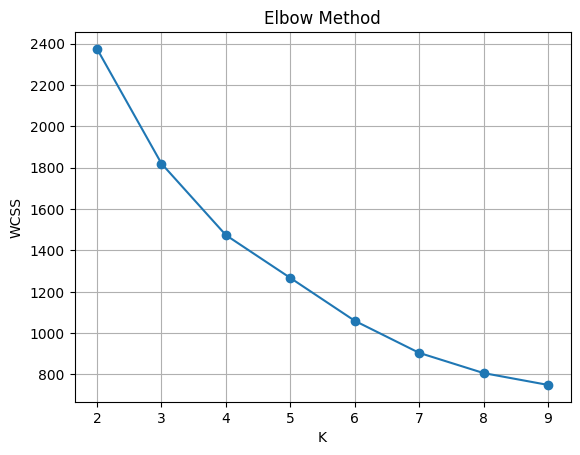

Clustering complete. Clusters assigned.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select clustering features
X_clust = customer_agg[['TotalSpending', 'Recency', 'AvgTransactionValue', 'Age']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# Elbow method
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2,10), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Final model (K=4 chosen visually)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_agg['Cluster'] = kmeans.fit_predict(X_scaled)

print("Clustering complete. Clusters assigned.")

#### **Step 5: Logistic Regression (Predict High Spenders)**


* Defined input features (`X`) and target (`y = IsHighSpender`):
  - Features included: `Recency`, `AvgTransactionValue`, `PurchaseFrequency`, `Cluster`, `Gender`, `AgeGroup`.
* Split data into **training (70%)** and **testing (30%)** sets.
* Built a preprocessing pipeline:
  - Numerical features were scaled.
  - Categorical features were one-hot encoded.
* Trained a **Logistic Regression** model with class weighting to handle imbalance.
* Evaluated performance using:
  - **Accuracy**: 97%
  - **Precision**: 86%
  - **Recall**: 100%
  - **ROC AUC**: 0.998
* Plotted the **ROC curve** to visualize model discrimination power.

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       240
           1       0.86      1.00      0.92        60

    accuracy                           0.97       300
   macro avg       0.93      0.98      0.95       300
weighted avg       0.97      0.97      0.97       300

ROC AUC: 0.997986111111111


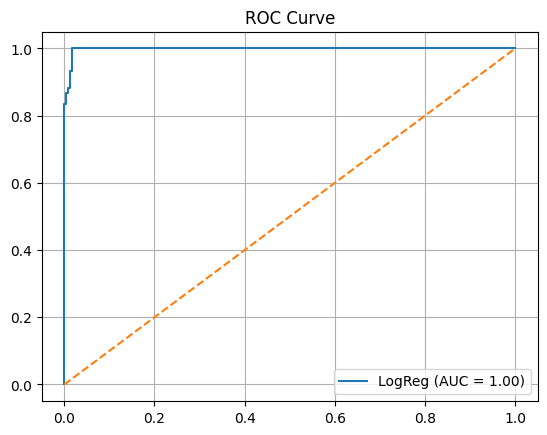

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define X and y
X = customer_agg[['Recency', 'AvgTransactionValue', 'PurchaseFrequency', 'Cluster', 'Gender', 'AgeGroup']]
y = customer_agg['IsHighSpender']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['Recency', 'AvgTransactionValue', 'PurchaseFrequency']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Cluster', 'Gender', 'AgeGroup'])
])

# Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced'))
])

# Fit and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve")
plt.grid()
plt.show()

#### **Step 6: Cluster Profiling & Insights**

* Grouped customers by cluster to analyze average behavior:
  - **Cluster 0**: Mature Regulars – Older customers, moderate spending, prefers clothing.
  - **Cluster 1**: High-Value Tech Enthusiasts – Highest spending, middle-aged, electronics lovers.
  - **Cluster 2**: Recent Active Shoppers – Low spending, most recent purchases, younger-middle aged, electronics buyers.
  - **Cluster 3**: Young & Lapsed/Occasional – Least recent, youngest group, prefers clothing.
* Visualized the size of each cluster using a bar chart:
  - Cluster sizes:  
    - Cluster 0: 287  
    - Cluster 1: 258  
    - Cluster 2: 256  
    - Cluster 3: 199  

Cluster Profiles:
          TotalSpending     Recency        Age  Size
Cluster                                            
0           153.728223  219.003484  54.864111   287
1          1306.976744  181.406977  40.507752   258
2           160.019531   72.414062  36.480469   256
3           169.422111  270.286432  29.427136   199


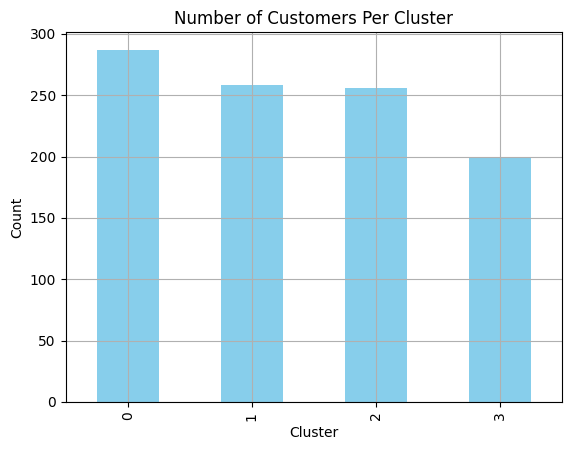

In [ ]:
# Cluster profiling
cluster_profile = customer_agg.groupby('Cluster')[['TotalSpending', 'Recency', 'Age']].mean()
cluster_profile['Size'] = customer_agg['Cluster'].value_counts()
print("Cluster Profiles:\n", cluster_profile)

# Plot cluster sizes
customer_agg['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Customers Per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#### **Step 7: Strategic Recommendations**

* Based on cluster profiles and predictive modeling results:
  - **Cluster 0: Mature Regulars**
    - Offer loyalty programs and email marketing.
    - Promote classic styles and comfort wear.
  - **Cluster 1: High-Value Tech Enthusiasts**
    - Provide exclusive offers and early access to new tech products.
    - Encourage reviews and testimonials.
  - **Cluster 2: Recent Active Shoppers**
    - Welcome offers and discounts to increase average transaction value.
    - Showcase diverse product categories.
  - **Cluster 3: Young & Lapsed/Occasional**
    - Launch re-engagement campaigns (“We miss you!”).
    - Promote fast fashion and seasonal trends via social media.
* Advised refining the logistic regression model to avoid **data leakage** caused by `AvgTransactionValue` being directly tied to `TotalSpending`.
* Recommended monitoring segment migration over time to adjust strategies dynamically.
